In [ ]:
# Check what gpu you are connected with
!nvidia-smi

Thu Nov  4 07:36:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mounts your drive
def MountDrive() -> str:
    from google.colab import drive
    drive_directory:str = "/content/drive"
    drive.mount(drive_directory)
    return drive_directory

# Functions to help with using your drive
def CopyFolder(copy_from:str, copy_to:str):
    !mkdir -p $copy_to
    %cp -av $copy_from $copy_to

In [ ]:
# Imports
import torch
from torch import nn
from torch import optim
from torch.utils.data import dataset, dataloader
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.models.resnet import resnet34

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import math

from collections import Counter, OrderedDict
import re

import os
import tarfile
import shutil

import requests
from bs4 import BeautifulSoup
from requests.structures import CaseInsensitiveDict

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
class WebScraperSetup():
    def __init__(self, url:str, save_dir:str, iteration_amount:int):
        self.url = url + "?page="

        self.headers = CaseInsensitiveDict()
        self.headers["User-Agent"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:93.0) Gecko/20100101 Firefox/93.0"
        self.headers["Accept"] = "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,/;q=0.8"
        self.headers["Accept-Language"] = "en-US,en;q=0.5"
        self.headers["DNT"] = "1"
        self.headers["Connection"] = "keep-alive"
        self.headers["Cookie"] = "hn_exp_kpis=370; hn_exp_slblc=816; hn_exp_hbcl=398; hn_exp_nadc=52; hn_exp_slt=974; _hemnet_session_id=J7PQJD5WV9ORgsr38sPoVcnTeaFhanMWNnTe3yDUx%2BAmWK2%2BytXuO3armliZ1fdZ3X0bE9WtB78V6SAnloAkyt%2F7FIzMc2RcKJAlRbAF4N05ToA%2BdpPONQbDOibx%2BcZT0Xl1pFFtWJgqvdS%2B9JZ6BgFHkHBE2gp3fAc2oNLgKX%2B0QQ%3D%3D--1%2F%2F5%2BzKi%2Fy10b1mZ--g6nmHm1sCnTBNkEq3DnGGg%3D%3D; cfruid=fb1df3017948bac7571bb6969b1ee4d762dbd510-1635326277; _hemnet_listing_result_settings_list=normal; _hemnet_listing_result_settingssorting=creation+desc; lpVp1=true"
        self.headers["Upgrade-Insecure-Requests"] = "1"
        self.headers["Sec-Fetch-Dest"] = "document"
        self.headers["Sec-Fetch-Mode"] = "navigate"
        self.headers["Sec-Fetch-Site"] = "none"
        self.headers["Sec-Fetch-User"] = "?1"

        self.save_dir = save_dir
        !mkdir -p $save_dir

        self.iteration_amount = iteration_amount
        self.page_index = 0
        self.iteration_index = 0

    def __call__(self, iteration_amount:int, page_index:int = 0):
        self.iteration_amount = iteration_amount
        self.page_index = page_index
        self.iteration_index = 0
        return self

class WebScraperSingle(WebScraperSetup):
    ''' Scrapes page_url for images and downloads them. Returns tuple holding [0]:path, [1]:label '''
    def __init__(self, url:str, save_dir:str, iteration_amount:int = 1_000_000):
        super(WebScraperSingle, self).__init__(url, save_dir, iteration_amount)
    
    def __iter__(self) -> tuple:
        while True:
            page = requests.get(f"{self.url}{self.page_index}", headers=self.headers)
            if page.status_code == 200:
                soup = BeautifulSoup(page.content, 'html.parser')
                items = soup.find_all(class_="normal-results__hit js-normal-list-item")
                
                if len(items) == 0:
                    return

                for item in items:
                    try:
                        if self.iteration_amount <= self.iteration_index:
                            return

                        price_object:str = item.find(class_="listing-card__attribute").text
                        price:str = "".join([ele for ele in price_object if ele.isdigit()])

                        if(price == ""):
                            continue

                        image_object:str = item.find(class_="js-lazy-load")
                        image_url:str = image_object['data-src']

                        r = requests.get(image_url, stream = True, headers=self.headers)
                        if r.status_code == 200:
                            r.raw.decode_content = True
                            image_dir = f"{self.save_dir}{self.iteration_index}_{price}.jpg"
                            with open(image_dir, 'wb') as f:
                                shutil.copyfileobj(r.raw, f)

                            self.iteration_index += 1
                            yield(image_dir, float(price))
                    except:
                        continue

            self.page_index += 1

In [ ]:
# Split dataset
class Splitter():
    def __init__(self, valid_pct=0.1, seed = None):
        self.seed = seed
        self.valid_pct = valid_pct
    
    def __call__(self, dataset):
        return train_test_split(dataset, test_size=self.valid_pct, random_state=np.random.RandomState(self.seed))

In [ ]:
# Holds one dataset
class HousingDataset(dataset.Dataset):
    def __init__(self, data, tfms=None):
        super(HousingDataset, self).__init__()
        self.data = data
        self.transforms = tfms
    
    def __getitem__(self, idx):
        X = Image.open(self.data[idx][0])
        if X.mode != 'RGB':
            X = X.convert('RGB')
        y = self.data[idx][1]
        if self.transforms:
            X = self.transforms(X)
        return (X, y)
    
    def __len__(self):
        return len(self.data)

In [ ]:
# Holds multiple housing datasets
class DatasetManager():
    def __init__(self, dataset, tfms=None, valid_pct=0.1, seed=None):
        self.tfms = tfms
        self.train_data, self.valid_data = Splitter(valid_pct=valid_pct, seed=seed)(dataset)
    
    @property
    def train_dataset(self):
        return HousingDataset(self.train_data, tfms=self.tfms)

    @property
    def valid_dataset(self):    
        return HousingDataset(self.valid_data, tfms=self.tfms)

In [ ]:
%cd /content/
MountDrive()

# web_scraper = WebScraperSingle("https://www.hemnet.se/bostader", "/content/Hemnet/")
# my_raw_dataset: list = []
# for data in web_scraper:
#     print(data)
#     my_raw_dataset.append(data)
# !tar -czvf /content/drive/MyDrive/Colab\ Notebooks/Datasets/Hemnet.tar.gz $web_scraper.save_dir

!tar -xzvf /content/drive/MyDrive/Colab\ Notebooks/Datasets/Hemnet.tar.gz -C /
my_raw_dataset: list = []
for subdir, dirs, files in os.walk("/content"):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".jpg"):
            my_raw_dataset.append((filepath, float(filename.split("_")[1][:-4])))

print(len(my_raw_dataset))

/content
Mounted at /content/drive
content/Hemnet/
content/Hemnet/824_2495000.jpg
content/Hemnet/329_1350000.jpg
content/Hemnet/912_2245000.jpg
content/Hemnet/175_1675000.jpg
content/Hemnet/2063_1495000.jpg
content/Hemnet/2154_1275000.jpg
content/Hemnet/157_2100000.jpg
content/Hemnet/1844_1695000.jpg
content/Hemnet/2355_3595000.jpg
content/Hemnet/1284_475000.jpg
content/Hemnet/2232_1795000.jpg
content/Hemnet/2018_5695000.jpg
content/Hemnet/2501_795000.jpg
content/Hemnet/2188_1649000.jpg
content/Hemnet/1884_2550000.jpg
content/Hemnet/50_9995000.jpg
content/Hemnet/608_2895000.jpg
content/Hemnet/1929_2900000.jpg
content/Hemnet/1811_2225000.jpg
content/Hemnet/2099_2375000.jpg
content/Hemnet/1767_725000.jpg
content/Hemnet/866_1700000.jpg
content/Hemnet/297_5475000.jpg
content/Hemnet/1472_4495000.jpg
content/Hemnet/1130_1595000.jpg
content/Hemnet/1492_1795000.jpg
content/Hemnet/2207_2695000.jpg
content/Hemnet/173_3950000.jpg
content/Hemnet/2061_2395000.jpg
content/Hemnet/218_1795000.jpg
cont

In [ ]:
dataset_manager = DatasetManager(
    my_raw_dataset,
    tfms=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)
train_dataset = dataset_manager.train_dataset
valid_dataset = dataset_manager.valid_dataset

In [ ]:
train_dataset[0]

(tensor([[[1.0000, 1.0000, 0.9961,  ..., 0.6941, 0.6863, 0.6863],
          [1.0000, 1.0000, 1.0000,  ..., 0.6980, 0.6902, 0.6863],
          [1.0000, 1.0000, 1.0000,  ..., 0.6980, 0.6902, 0.6902],
          ...,
          [0.5412, 0.5529, 0.5608,  ..., 0.5176, 0.4471, 0.4314],
          [0.5176, 0.5294, 0.5569,  ..., 0.6118, 0.6471, 0.4902],
          [0.5176, 0.5020, 0.5373,  ..., 0.6314, 0.5843, 0.5373]],
 
         [[1.0000, 1.0000, 0.9961,  ..., 0.8235, 0.8196, 0.8118],
          [1.0000, 1.0000, 1.0000,  ..., 0.8275, 0.8235, 0.8196],
          [1.0000, 1.0000, 1.0000,  ..., 0.8275, 0.8275, 0.8235],
          ...,
          [0.5020, 0.5137, 0.5216,  ..., 0.5529, 0.4392, 0.4118],
          [0.4784, 0.4902, 0.5176,  ..., 0.6588, 0.6627, 0.4824],
          [0.4784, 0.4627, 0.4980,  ..., 0.6902, 0.6157, 0.5333]],
 
         [[1.0000, 1.0000, 0.9961,  ..., 0.9569, 0.9490, 0.9608],
          [1.0000, 1.0000, 1.0000,  ..., 0.9608, 0.9529, 0.9608],
          [1.0000, 1.0000, 1.0000,  ...,

In [ ]:
def plot_one_batch(batch, max_images=9):
    nrows = int(math.sqrt(max_images))
    ncols = int(math.sqrt(max_images))
    if nrows * ncols != max_images:
        nrows = (max_images + ncols - 1) // ncols 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
    for i in range(max_images):
        X,Y = next(batch)
        ax.ravel()[i].imshow(transforms.ToPILImage()(X))
        ax.ravel()[i].set_title(f'{Y}')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
def generate_one_batch(dl):
    for batch in dl:
        yield batch

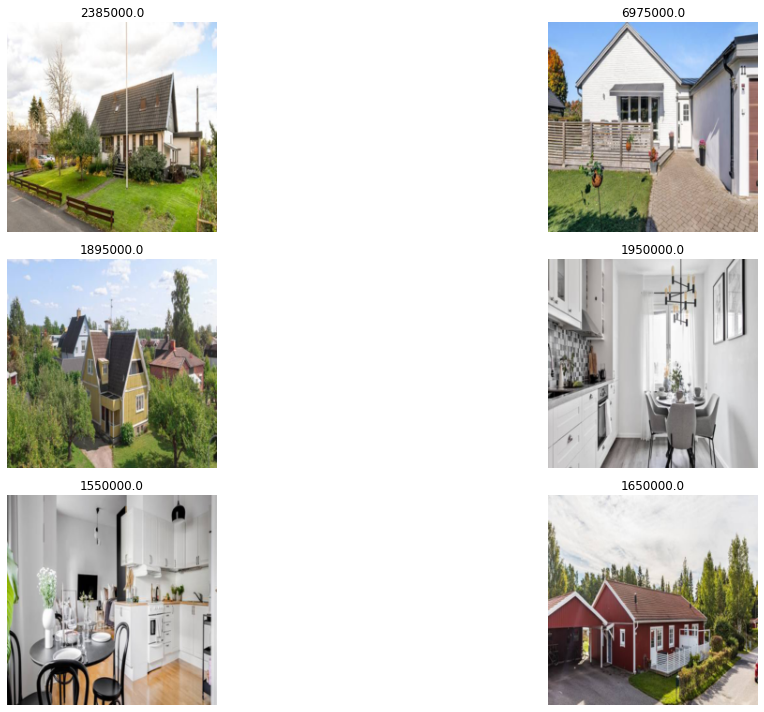

In [ ]:
plot_one_batch(generate_one_batch(train_dataset), max_images=6)

In [ ]:
model = resnet34(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model.fc = nn.Linear(512, 1, bias=True)

In [ ]:
def make_fine_tunable(model):
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    print("Tunable Layers: ")
    for (name, param) in model.named_parameters():
        if param.requires_grad:
            print(f'{name} -> {param.requires_grad}')

In [ ]:
make_fine_tunable(model)

Tunable Layers: 
fc.weight -> True
fc.bias -> True


In [ ]:
class Trainer():
    def __init__(self, train_dataloader, model, criterion, optimizer, test_dataloader=None):
        self.train_dl = train_dataloader
        self.model = model
        self.test_dl = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.recorder = {'loss': {
            'train': {}, 'test': {}}
            , 'accuracy': {'train': {}, 'test': {}}}
    
    def step_batch(self, X,y):
        X = X.cuda()
        y = y.cuda()
        logits = self.model(X)
        loss = self.criterion(logits, y)
        probs = F.softmax(logits, dim=1)
        return loss, logits, probs
    
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0
        for X,y in tqdm(self.train_dl, leave=False):
            self.optimizer.zero_grad()

            loss, _, _ = self.step_batch(X,y.float())
            running_loss += loss

            loss.backward()
            self.optimizer.step()
        
        epoch_loss = running_loss / len(self.train_dl)
        self.recorder['loss']['train'][epoch] = epoch_loss

        return epoch_loss

    @torch.no_grad()
    def accuracy(self):
        correct = 0
        total = 0

        for X,y in tqdm(self.test_dl):
            total += y.size(0)
            logits = model(X)
            probs = F.softmax(logits, dim=1)
            _, y_pred = torch.max(probs, dim=1)
            correct += (y_pred == y).sum()
        acc = correct / float(total)
        return acc


    @torch.no_grad()
    def validate(self, epoch):
        
        running_loss = 0
        total = 0
        correct = 0

        for X,y in tqdm(self.test_dl, leave=False):
            y = y.cuda()
            total += y.size(0)
            loss, logits, probs = self.step_batch(X,y.float())
            running_loss += loss
            correct += (torch.abs(logits - y)).cpu().sum()
        acc = correct / float(total)
        epoch_loss = running_loss / len(self.test_dl)
        self.recorder['loss']['test'][epoch] = epoch_loss
        self.recorder['accuracy']['test'][epoch] = acc
        return epoch_loss, acc
    
    def train(self, num_epochs):
        for epoch in tqdm(range(num_epochs), leave=False):
            train_loss = self.train_epoch(epoch)
            test_loss, test_acc = self.validate(epoch)
            print(f"Training Loss: {train_loss},\tTest Loss: {test_loss},\tTest Accuracy: {test_acc}")

In [ ]:
model = model.cuda()

In [ ]:
class TrainConfig():
    def __init__(self, bs=32, lr=1e-2, seed=42, betas=(0.9, 0.999), num_workers=4):
        self.bs = bs
        self.lr = lr
        self.seed = seed
        self.betas = betas
        self.num_workers = num_workers

In [ ]:
config = TrainConfig(bs=256)
torch.manual_seed(config.seed)
train_dl = dataloader.DataLoader(train_dataset, batch_size=config.bs, shuffle=True, num_workers=config.num_workers)
valid_dl = dataloader.DataLoader(valid_dataset, batch_size=config.bs, shuffle=False, num_workers=config.num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
criterion = nn.MSELoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=15000.0, betas=(0.9, 0.999), eps = 1_000.0)
trainer = Trainer(train_dl, model, criterion, optimizer, test_dataloader=valid_dl)
trainer.train(100)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([255])) that is different to the input size (torch.Size([255, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss: 1.3084166380301844e+18,	Test Loss: 1.4438197082844037e+18,	Test Accuracy: 1123625954.8431373


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training Loss: 8.981415019874877e+17,	Test Loss: 4.189412805343969e+17,	Test Accuracy: 389611525.9362745


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training Loss: 5.573290094619525e+17,	Test Loss: 6.010691969225851e+17,	Test Accuracy: 472570520.63235295


  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def plot_losses(losses):
    train_loss = losses['train']
    test_loss = losses['test']
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(train_loss, color='blue', label='Training Loss')
    ax.plot(test_loss, color='green', label='Test Loss')
    ax.set(title="Loss over epochs", xlabel="Epochs", ylabel="Loss")
    ax.legend()
    fig.show()
    plt.style.use('default')

In [ ]:
def plot_accuracy(accuracy):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(accuracy, color='blue', label='Test Accuracy')
    ax.set(title="Accuracy over epochs", xlabel="Epochs", ylabel="Accuracy")
    ax.legend()
    fig.show()
    plt.style.use('default')

In [ ]:
losses = { k: np.asarray([t.item() for t in v.values()]) for k,v in trainer.recorder['loss'].items() }
plot_losses(losses)

In [ ]:
accuracies = { k: np.asarray([t.item() for t in v.values()]) for k,v in trainer.recorder['accuracy'].items()}
plot_accuracy(accuracy=accuracies['test'])